In [ ]:
# 系統與檔案操作
import os
import shutil
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# 資料處理與資料科學工具
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# 圖像處理與影像操作
import cv2
from PIL import Image
from skimage.transform import resize
import albumentations as A

# 深度學習與 TensorFlow / Keras 相關
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Dropout,
    MaxPooling2D, Conv2DTranspose, Concatenate, Add
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
)
from tensorflow.keras.applications import EfficientNetB0

# 繪圖工具
import matplotlib.pyplot as plt

# Colab 特殊功能
from google.colab import files
from google.colab.patches import cv2_imshow

# 隨機性控制
import random


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 從Kaggle下載資料

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#kaggle API密鑰
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#建立.kaggle資料夾
!mkdir ~/.kaggle

#檢查上一段建立資料夾的程式有沒有執行成功
if os.path.exists('/root/.kaggle') == True:
  print("yes")
elif os.path.exists('/root/.kaggle') == False:
  print("NO")

yes


In [ ]:
#複製kaggle.json到.kaggle資料夾
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#下載kaggle比賽資料包
!kaggle competitions download -c severstal-steel-defect-detection

#解壓縮kaggle比賽資料包
!unzip -qq severstal-steel-defect-detection.zip

100% 1.56G/1.57G [00:14<00:00, 185MB/s]
100% 1.57G/1.57G [00:14<00:00, 115MB/s]


# Exploratory Data Analysis (EAD) - 探索性數據分析

In [ ]:
#查看train.csv檔案
train_data = pd.read_csv('train.csv')
train_data

ImageId  ClassId  \
0     0002cc93b.jpg        1   
1     0007a71bf.jpg        3   
2     000a4bcdd.jpg        1   
3     000f6bf48.jpg        4   
4     0014fce06.jpg        3   
...             ...      ...   
7090  ffcf72ecf.jpg        3   
7091  fff02e9c5.jpg        3   
7092  fffe98443.jpg        3   
7093  ffff4eaa8.jpg        3   
7094  ffffd67df.jpg        3   

                                          EncodedPixels  
0     29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1     18661 28 18863 82 19091 110 19347 110 19603 11...  
2     37607 3 37858 8 38108 14 38359 20 38610 25 388...  
3     131973 1 132228 4 132483 6 132738 8 132993 11 ...  
4     229501 11 229741 33 229981 55 230221 77 230468...  
...                                                 ...  
7090  121911 34 122167 101 122422 169 122678 203 122...  
7091  207523 3 207777 9 208030 15 208283 22 208537 2...  
7092  105929 5 106177 14 106424 24 106672 33 106923 ...  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
7094  30931 43 31103 127 31275 211 31489 253 31745 2...  

[7095 rows x 3 columns]

In [ ]:
#ClassId同一個值出現的次數
print(+train_data["ClassId"].value_counts())
print('合計：'+str(train_data["ClassId"].value_counts().sum()))

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64
合計：7095


In [ ]:
train_data['ImageId'] = train_data['ImageId'].apply(lambda x: x.strip())
train_data.ImageId.describe()

count              7095
unique             6666
top       ef24da2ba.jpg
freq                  3
Name: ImageId, dtype: object

In [ ]:
train_img_set = set(list(os.listdir('train_images')))
print('train_images照片有幾張：', len(train_img_set))
defect_img_set = set(train_data['ImageId'].values)
print('有瑕疵的照片有幾張', len(defect_img_set))
print('沒有有瑕疵的照片有幾張', len(train_img_set)-len(defect_img_set))
if (defect_img_set.issubset(train_img_set)):
    print('而且在csv檔中被提及的ImageId都在train_images資料夾中')


train_images照片有幾張： 12568
有瑕疵的照片有幾張 6666
沒有有瑕疵的照片有幾張 5902
而且在csv檔中被提及的ImageId都在train_images資料夾中


In [ ]:
#查看train_image有幾張圖片
count=0
walk = os.walk('/content/train_images')
root, dirs, files = next(walk)
#root表示/content/test_images本身的位置；dirs表示該文件夾中所有的目錄的名字；files該文件夾中所有的文件
print(len(files))


12568


In [ ]:
#查看test_image有幾張圖片
count=0
walk = os.walk('/content/test_images')
root, dirs, files = next(walk)
#root表示/content/test_images本身的位置；dirs表示該文件夾中所有的目錄的名字；files該文件夾中所有的文件
print(len(files))

5506


In [ ]:
#看一下圖片大小還有通道
img_shapes = set()
for img in list(os.listdir('train_images')):
    img_shapes.add(cv2.imread('train_images/'+img).shape)
img_shapes

{(256, 1600, 3)}

<ipython-input-19-f1922a370da7>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for i, img_id in enumerate(random.sample(defect_img_set, 10)):


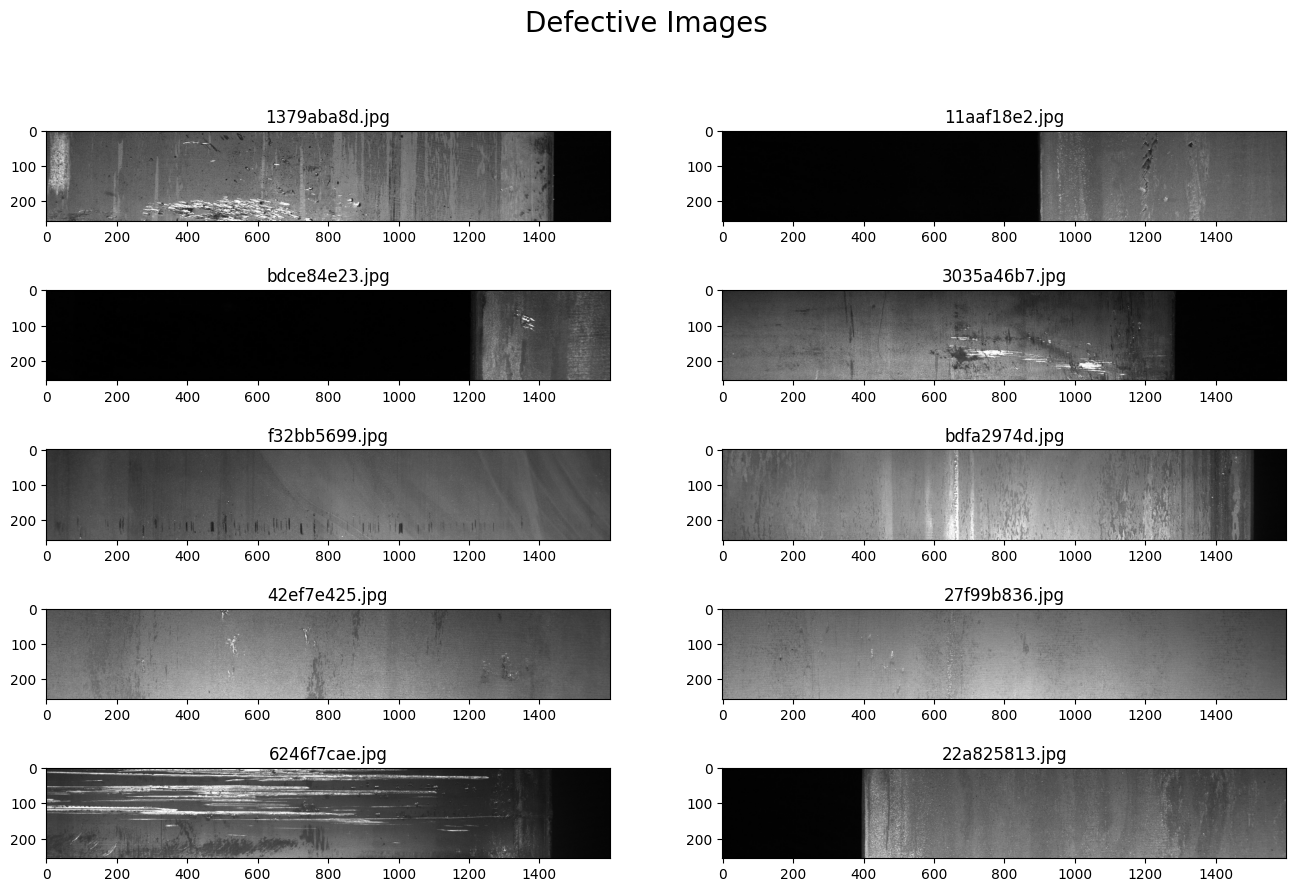

In [ ]:
#有瑕疵的圖像
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(random.sample(defect_img_set, 10)):
    img_obj = cv2.imread('/content/train_images/'+ img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)

plt.show()


In [ ]:
#https://www.kaggle.com/titericz/building-and-visualizing-masks
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

#defining function for converting EncodedPixels(rle: run length encoding,遊程編碼) to mask
# def rle2mask(rle_string, img_shape=(256,1600)):
#     '''
#     input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
#     output: mask in numpy.ndarray format with shape (256,1600)
#     '''
#     rle_array = np.array([int(s)for s in rle_string.split()])
#     starts_array = rle_array[::2]-1
#     lengths_array = rle_array[1::2]
#     mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
#     #print(starts_array,lengths_array)
#     for i in range(len(starts_array)):
#         mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
#     #order='F' because encoded pixels are numbered from top to bottom, then left to right
#     return mask_array.reshape(img_shape, order = 'F')

def rle2mask(rle_string, img_shape=(128, 800)):
    if pd.isna(rle_string):
        return np.zeros(img_shape, dtype=np.uint8)

    rle_array = np.array([int(s) for s in rle_string.split()])
    starts_array = rle_array[::2] - 1
    lengths_array = rle_array[1::2]


    full_mask = np.zeros(256 * 1600, dtype=np.uint8)

    for start, length in zip(starts_array, lengths_array):
        full_mask[start:start+length] = 1


    full_mask = full_mask.reshape((256, 1600), order='F')


    resized_mask = resize(full_mask, img_shape, order=0, preserve_range=True, anti_aliasing=False)

    return resized_mask.astype(np.uint8)


#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string


In [ ]:
#checking if rle2mask & mask2rle are working as required
mask2rle(rle2mask(train_data['EncodedPixels'].iloc[0])) == train_data['EncodedPixels'].iloc[0]


True

<ipython-input-27-5d661cfa66b9>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for i, img_id in enumerate(random.sample(set(class_df['ImageId'].values), 5)):


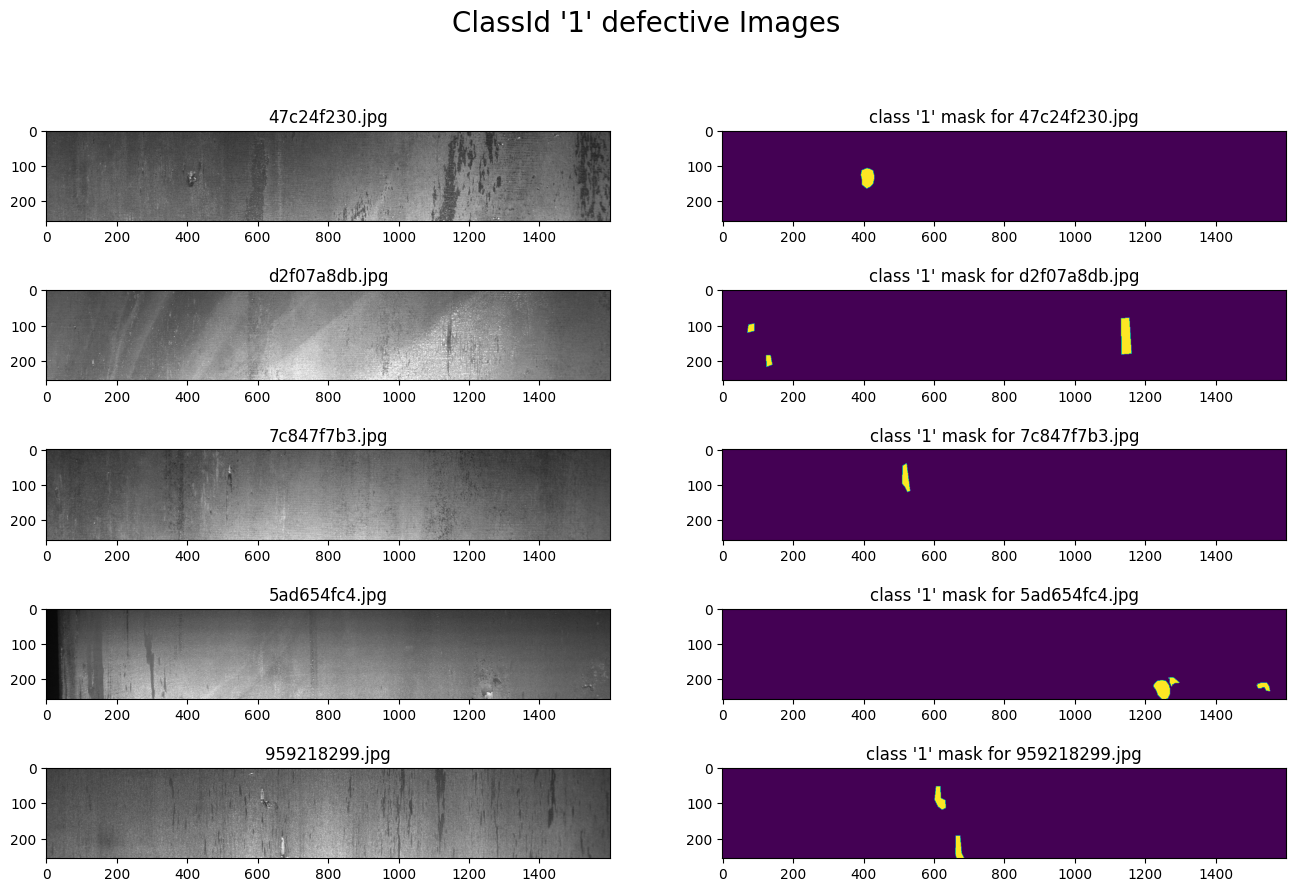

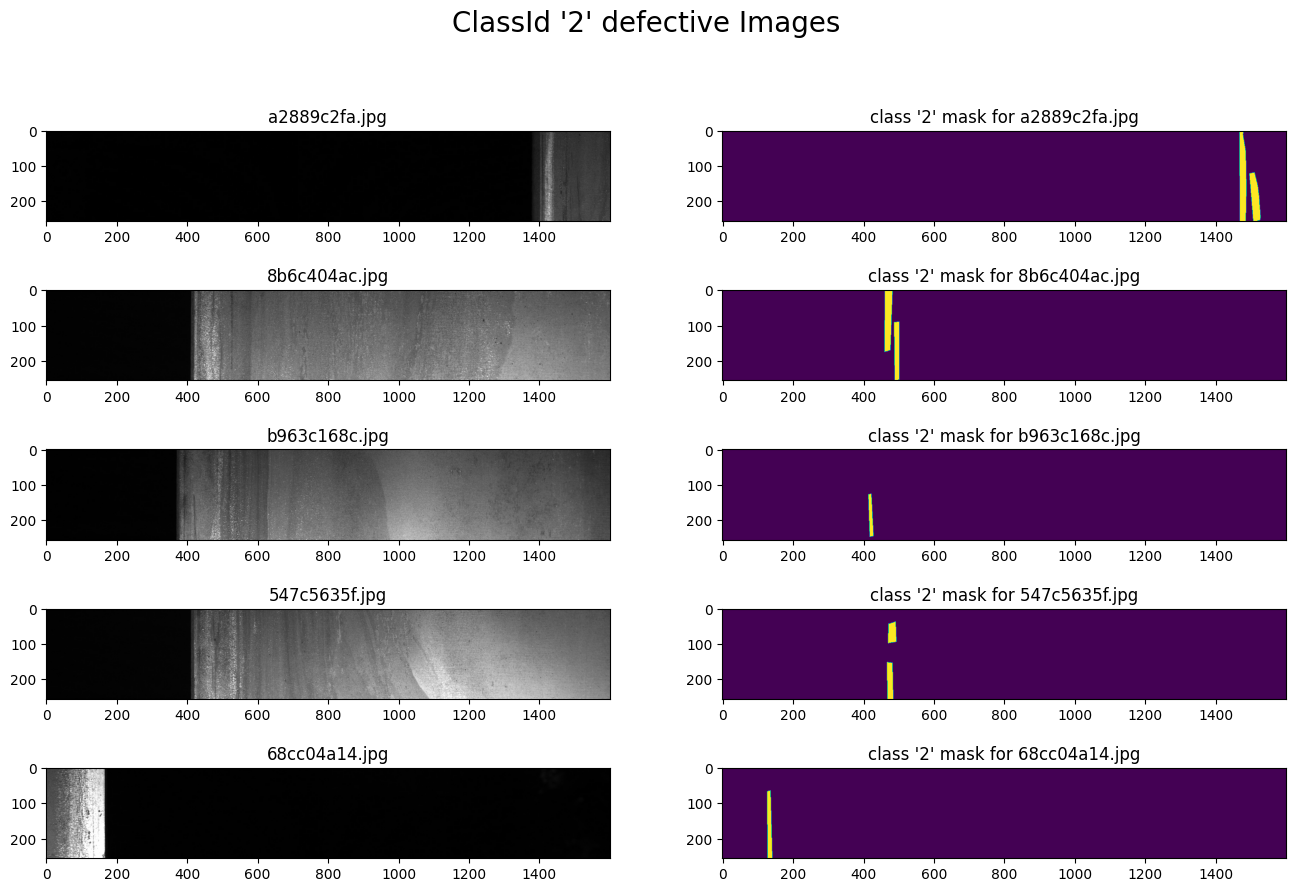

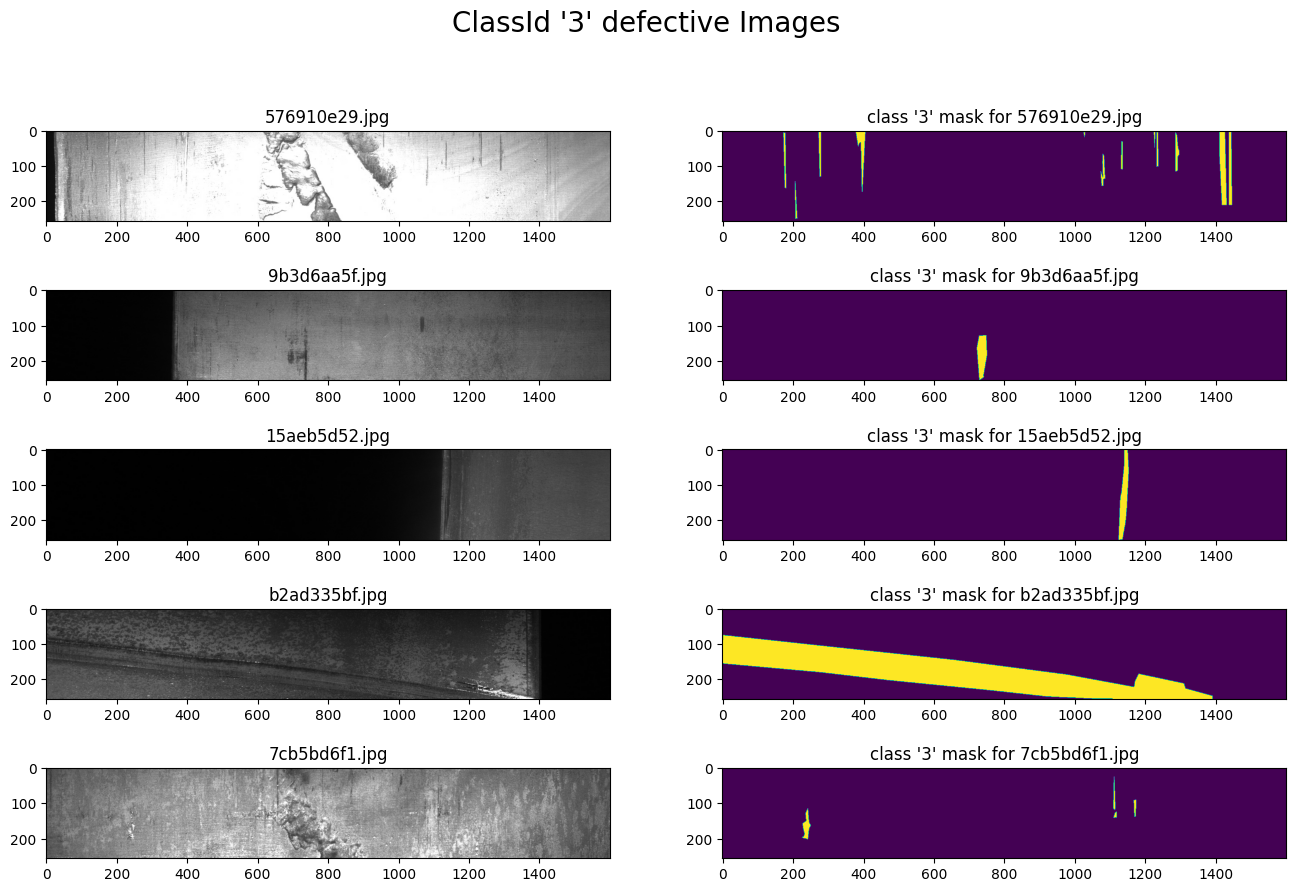

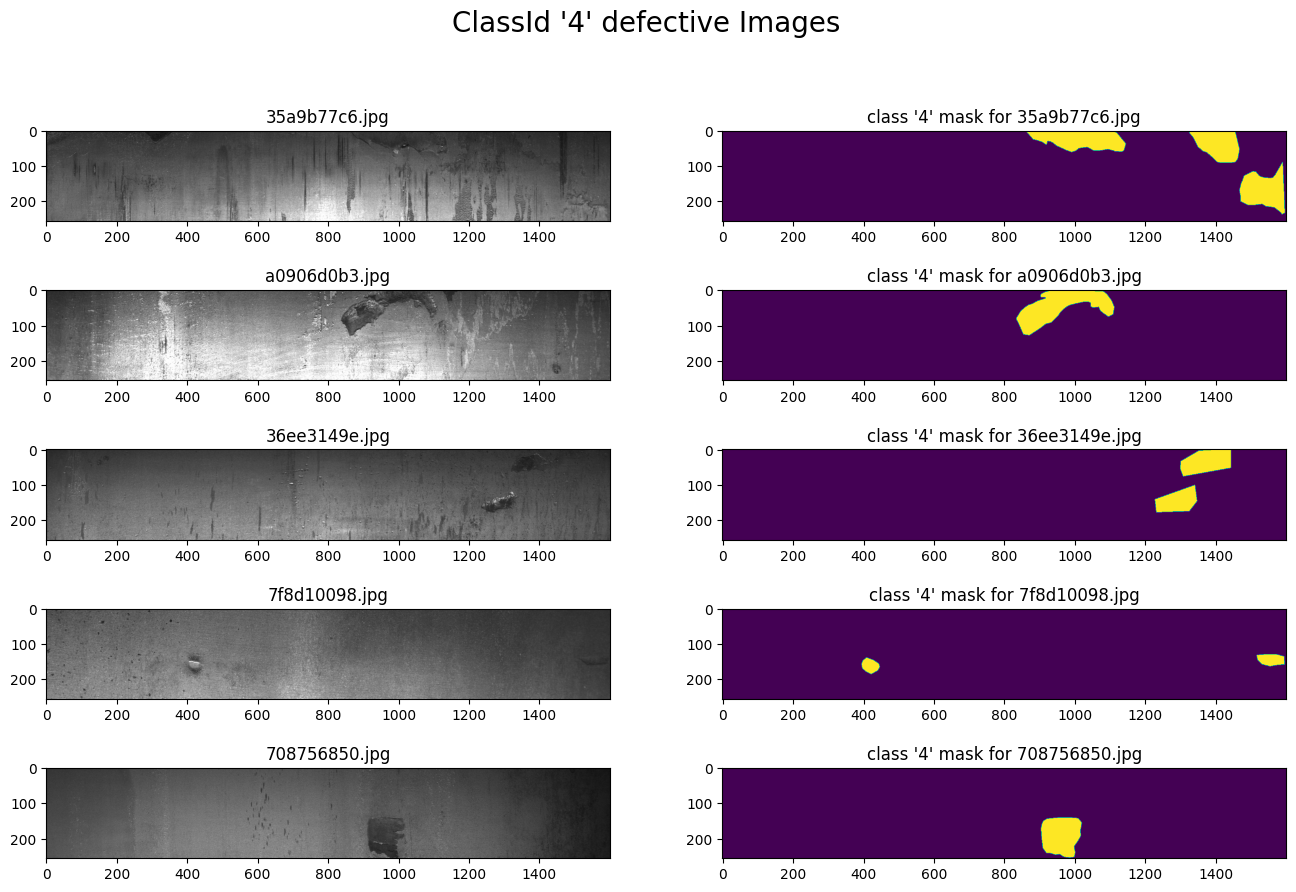

In [ ]:
#依瑕疵類別看有瑕疵的圖像
for ClassId in [1,2,3,4]:
    class_df = train_data[train_data['ClassId'] == ClassId]
    fig, axs = plt.subplots(5, 2, figsize=(16,10))
    fig.suptitle("ClassId '{}' defective Images".format(ClassId), fontsize=20)
    x,y = 0,0
    for i, img_id in enumerate(random.sample(set(class_df['ImageId'].values), 5)):
        img_obj = cv2.imread('/content/train_images/'+ img_id)
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        rle = class_df[class_df['ImageId'] == img_id]['EncodedPixels'].iloc[0]
        mask = rle2mask(rle,(256,1600))
        axs[i,1].imshow(mask)
        axs[i,1].set_title("class '{}' mask for ".format(ClassId) + img_id)
    plt.show()
    print('='*100)


### EAD總結

A.瑕疵分為4類，一張圖可能沒有瑕疵或有一種以上的瑕疵 \
B.資料存在嚴重的資料不平衡 \
C.在csv檔中被提及的ImageId都在train_images資料夾中 \
D.所有圖片大小為256*1600且有3通道 \


# 資料預處理

A.整理dataframe以利後續使用 \
B.分割訓練、驗證和測試數據 \
C.處理資料不平衡 \
D.圖像處理 \

In [ ]:
train_images_list=list(os.listdir('/content/train_images'))
train_images_length=len(train_images_list)
train_images_list=train_images_list*4
ClassIds=[1]*train_images_length+[2]*train_images_length+[3]*train_images_length+[4]*train_images_length

full_df=pd.DataFrame({'ImageId':train_images_list, 'ClassId':ClassIds})
full_df=full_df.sort_values(by=['ImageId','ClassId']).reset_index(drop=True)
full_df=pd.merge(full_df,train_data,how='outer',on=['ImageId','ClassId'])
full_df

ImageId  ClassId  \
0      0002cc93b.jpg        1   
1      0002cc93b.jpg        2   
2      0002cc93b.jpg        3   
3      0002cc93b.jpg        4   
4      00031f466.jpg        1   
...              ...      ...   
50267  ffff4eaa8.jpg        4   
50268  ffffd67df.jpg        1   
50269  ffffd67df.jpg        2   
50270  ffffd67df.jpg        3   
50271  ffffd67df.jpg        4   

                                           EncodedPixels  
0      29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4                                                    NaN  
...                                                  ...  
50267                                                NaN  
50268                                                NaN  
50269                                                NaN  
50270  30931 43 31103 127 31275 211 31489 253 31745 2...  
50271                                                NaN  

[50272 rows x 3 columns]

In [ ]:
full_df = pd.pivot_table(full_df, columns = ['ClassId'], index= ['ImageId'], aggfunc=np.sum).replace(0,'')
full_df = full_df.reset_index()
full_df.columns = ['ImageId', 'rle_1', 'rle_2', 'rle_3', 'rle_4']
full_df.to_csv("full_data.csv", index=False)
print('Shape of full_df: ', full_df.shape)
full_df.head()

<ipython-input-11-e44aa9521ec2>:1: FutureWarning: The provided callable <function sum at 0x7ca96f5e40d0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  full_df = pd.pivot_table(full_df, columns = ['ClassId'], index= ['ImageId'], aggfunc=np.sum).replace(0,'')


Shape of full_df:  (12568, 5)


ImageId                                              rle_1 rle_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...         
1  00031f466.jpg                                                            
2  000418bfc.jpg                                                            
3  000789191.jpg                                                            
4  0007a71bf.jpg                                                            

                                               rle_3 rle_4  
0                                                           
1                                                           
2                                                           
3                                                           
4  18661 28 18863 82 19091 110 19347 110 19603 11...

In [ ]:
full_data = pd.read_csv('full_data.csv').fillna('')
full_data.head()

ImageId                                              rle_1 rle_2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...         
1  00031f466.jpg                                                            
2  000418bfc.jpg                                                            
3  000789191.jpg                                                            
4  0007a71bf.jpg                                                            

                                               rle_3 rle_4  
0                                                           
1                                                           
2                                                           
3                                                           
4  18661 28 18863 82 19091 110 19347 110 19603 11...

In [ ]:
# 切割訓練集、驗證集和測試集
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15



data_train_validtn, test_data = train_test_split(full_data, test_size=test_ratio, random_state=42)
train_data, validtn_data = train_test_split(data_train_validtn,
                                            test_size=validation_ratio/(validation_ratio + train_ratio),
                                            random_state=42)
print(train_data.shape)
print(validtn_data.shape)
print(test_data.shape)


(8796, 5)
(1886, 5)
(1886, 5)


In [ ]:
train_data.to_csv("train_data.csv", index=False)
validtn_data.to_csv("validtn_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [ ]:
def process_data(train_data):
    # 複製原始數據
    processed_data = train_data.copy()
    processed_data['augment'] = False

    # 處理 rle_1
    rle_1_augmented = processed_data[processed_data['rle_1'].notna() & (processed_data['rle_1'].str.strip() != "")].copy()
    rle_1_augmented = pd.concat([rle_1_augmented] * 2, ignore_index=True)
    rle_1_augmented['augment'] = True
    rle_1_augmented['rle_2'] = ""
    rle_1_augmented['rle_3'] = ""
    rle_1_augmented['rle_4'] = ""

    # 處理 rle_2
    rle_2_augmented = processed_data[processed_data['rle_2'].notna() & (processed_data['rle_2'].str.strip() != "")].copy()
    rle_2_augmented = pd.concat([rle_2_augmented] * 7, ignore_index=True)
    rle_2_augmented['augment'] = True
    rle_2_augmented['rle_1'] = ""
    rle_2_augmented['rle_3'] = ""
    rle_2_augmented['rle_4'] = ""

    # 處理 rle_4
    rle_4_augmented = processed_data[processed_data['rle_4'].notna() & (processed_data['rle_4'].str.strip() != "")].copy()
    rle_4_augmented = pd.concat([rle_4_augmented] * 2, ignore_index=True)
    rle_4_augmented['augment'] = True
    rle_4_augmented['rle_1'] = ""
    rle_4_augmented['rle_2'] = ""
    rle_4_augmented['rle_3'] = ""

    # 合併所有擴增的數據
    augmented_data = pd.concat([processed_data, rle_1_augmented, rle_2_augmented, rle_4_augmented], ignore_index=True)

    # 處理 rle_3
    rle_3_mask = (augmented_data['rle_3'].notna() & (augmented_data['rle_3'].str.strip() != ""))
    rle_3_indices = augmented_data[rle_3_mask].index
    drop_indices = np.random.choice(rle_3_indices, size=int(len(rle_3_indices) * 0.4), replace=False)
    final_data = augmented_data.drop(drop_indices)

    # 確保 augment 列的類型為 boolean
    final_data['augment'] = final_data['augment'].astype(bool)

    return final_data




train_data_aug=process_data(train_data)
# 保存結果，不包含索引
train_data_aug.to_csv('train_data_aug.csv', index=False)

print(f"Original data length: {len(train_data)}")
print(f"New data length: {len(train_data_aug)}")
print(f"Number of new rows added: {len(train_data_aug) - len(train_data)}")

Original data length: 8796
New data length: 10979
Number of new rows added: 2183


In [ ]:
def count_non_empty(series):
    return series.apply(lambda x: pd.notna(x) and x.strip() != "").sum()


rle_counts = {
    'rle_1': count_non_empty(train_data_aug['rle_1']),
    'rle_2': count_non_empty(train_data_aug['rle_2']),
    'rle_3': count_non_empty(train_data_aug['rle_3']),
    'rle_4': count_non_empty(train_data_aug['rle_4'])
}


for col, count in rle_counts.items():
    print(f"{col} 非空值的數量: {count}")


total_rows = len(train_data_aug)
print(f"\n總行數: {total_rows}")


for col, count in rle_counts.items():
    percentage = (count / total_rows) * 100
    print(f"{col} 非空值佔總行數的百分比: {percentage:.2f}%")

rle_1 非空值的數量: 1883
rle_2 非空值的數量: 1419
rle_3 非空值的數量: 2156
rle_4 非空值的數量: 1570

總行數: 10979
rle_1 非空值佔總行數的百分比: 17.15%
rle_2 非空值佔總行數的百分比: 12.92%
rle_3 非空值佔總行數的百分比: 19.64%
rle_4 非空值佔總行數的百分比: 14.30%


In [ ]:

rle_counts = {
    'rle_1': count_non_empty(train_data['rle_1']),
    'rle_2': count_non_empty(train_data['rle_2']),
    'rle_3': count_non_empty(train_data['rle_3']),
    'rle_4': count_non_empty(train_data['rle_4'])
}


for col, count in rle_counts.items():
    print(f"{col} 非空值的數量: {count}")


total_rows = len(train_data)
print(f"\n總行數: {total_rows}")


for col, count in rle_counts.items():
    percentage = (count / total_rows) * 100
    print(f"{col} 非空值佔總行數的百分比: {percentage:.2f}%")

rle_1 非空值的數量: 637
rle_2 非空值的數量: 178
rle_3 非空值的數量: 3593
rle_4 非空值的數量: 550

總行數: 8796
rle_1 非空值佔總行數的百分比: 7.24%
rle_2 非空值佔總行數的百分比: 2.02%
rle_3 非空值佔總行數的百分比: 40.85%
rle_4 非空值佔總行數的百分比: 6.25%


In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smoothing_const)

#defining function for calculation of dice coefficient
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coefficient(y_true, y_pred))

#defining function for calculation of loss function: binary cross entropy + dice loss
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coefficient(y_true, y_pred))


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, is_training=True,
                 h_flip_prob=0.5, v_flip_prob=0.5, noise_prob=0.5, noise_std=0.1):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_training = is_training
        self.indices = self.df.index.tolist()
        self.h_flip_prob = h_flip_prob
        self.v_flip_prob = v_flip_prob
        self.noise_prob = noise_prob
        self.noise_std = noise_std
        self.on_epoch_end()
        print(f"DataGenerator initialized with is_training={self.is_training}")

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self._get_data(indices)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_data(self, batch):
        X = np.empty((len(batch), 128, 800, 1), dtype=np.float32)
        Y = np.empty((len(batch), 128, 800, 4), dtype=np.float32)

        for i, id in enumerate(batch):
            #print(f"Processing image {id}, is_training={self.is_training}")


            img = Image.open('/content/train_images/' + str(self.df['ImageId'].loc[id])).convert('L')
            img_array = np.array(img)
            img_resized = resize(img_array, (128, 800), anti_aliasing=True)


            mean = np.mean(img_resized)
            std = np.std(img_resized) if np.std(img_resized) > 1e-7 else 1e-7
            img_zscore = (img_resized - mean) / std
            img_zscore = np.expand_dims(img_zscore, axis=-1)  # (128, 800, 1)


            masks = np.zeros((128, 800, 4), dtype=np.float32)
            for j in range(4):
                rle = self.df[f'rle_{j + 1}'].loc[id]
                mask = rle2mask(rle, img_shape=(128, 800))
                masks[:, :, j] = mask


            if self.is_training:
                # 水平翻轉
                if np.random.rand() < self.h_flip_prob:
                    #print("Applying horizontal flip")
                    img_zscore = np.fliplr(img_zscore)
                    masks = np.fliplr(masks)

                # 垂直翻轉
                if np.random.rand() < self.v_flip_prob:
                    #print("Applying vertical flip")
                    img_zscore = np.flipud(img_zscore)
                    masks = np.flipud(masks)

                # 噪音
                if np.random.rand() < self.noise_prob:
                    #print("Applying noise")
                    noise = np.random.normal(0, self.noise_std, img_zscore.shape)
                    img_zscore += noise
                    img_zscore = np.clip(img_zscore, -1, 1)
            # else:
            #     print("Not applying augmentation (is_training=False)")

            X[i] = img_zscore
            Y[i] = masks

        return X, Y

In [ ]:
train_batches = DataGenerator(train_data_aug,shuffle=True,is_training=True)
validtn_batches = DataGenerator(validtn_data,shuffle=False,is_training=False)
test_batches = DataGenerator(test_data,shuffle=False,is_training=False)

DataGenerator initialized with is_training=True
DataGenerator initialized with is_training=False
DataGenerator initialized with is_training=False


In [ ]:
#看一下增強前後的差異
def visualize_image_by_id(generator, image_id):
    if image_id not in generator.df['ImageId'].values:
        print(f"Error: ImageId {image_id} 不存在于 dataframe 中")
        return

    image_index = generator.df[generator.df['ImageId'] == image_id].index[0]

    # 原始圖像
    generator.is_training = False
    X_original, Y_original = generator._get_data([image_index])

    # 增強後的圖像
    generator.is_training = True
    X_augmented, Y_augmented = generator._get_data([image_index])

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # 原圖像與mask
    axes[0, 0].imshow(X_original[0, :, :, 0], cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    for j in range(4):
        mask = Y_original[0, :, :, j]
        axes[0, j + 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
        axes[0, j + 1].set_title(f'Original Mask {j + 1}')
        axes[0, j + 1].axis('off')

    # 增強後圖像與mask
    axes[1, 0].imshow(X_augmented[0, :, :, 0], cmap='gray')
    axes[1, 0].set_title('Augmented Image (Vertical Flip)')
    axes[1, 0].axis('off')

    for j in range(4):
        mask = Y_augmented[0, :, :, j]
        axes[1, j + 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
        axes[1, j + 1].set_title(f'Augmented Mask {j + 1}')
        axes[1, j + 1].axis('off')

    plt.tight_layout()
    plt.show()

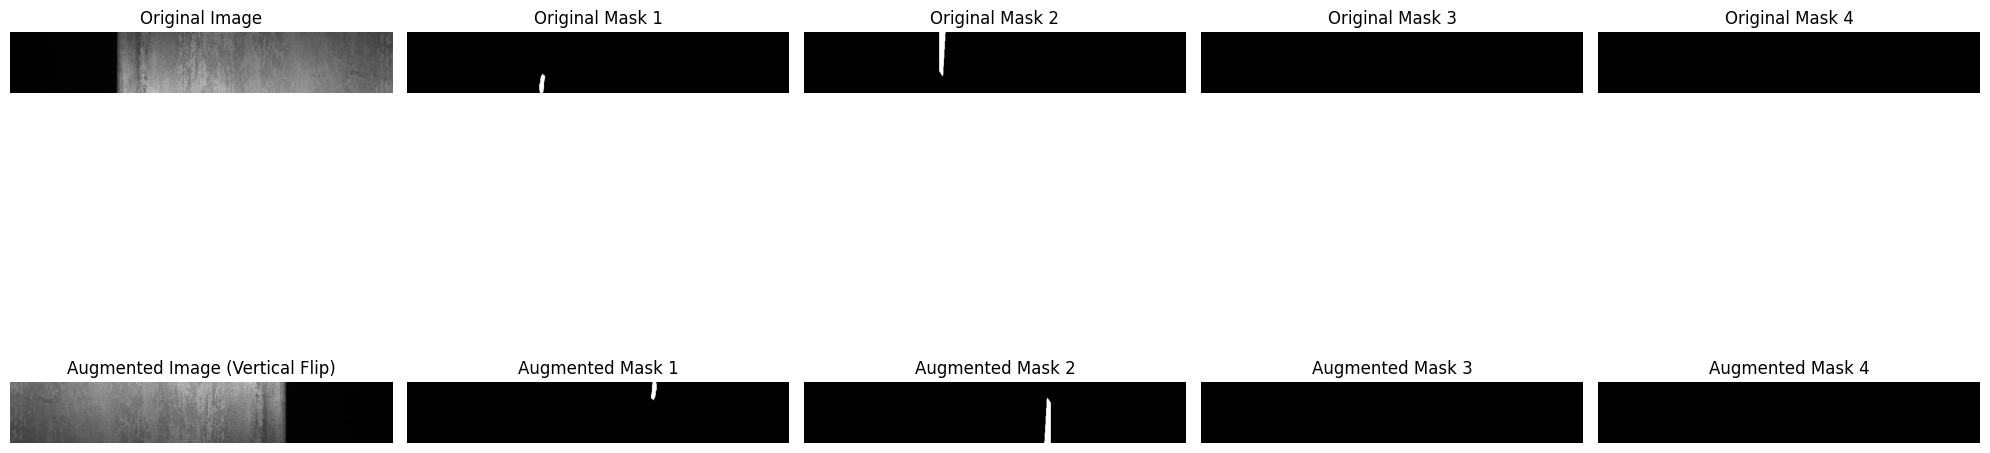

In [ ]:
visualize_image_by_id(train_batches, 'fb9a07c8f.jpg')

# 建模與訓練

In [ ]:


def create_deeplabv3(input_shape=(128, 800, 1), num_classes=4):
    # 輸入層，將單通道轉為 3 通道
    inputs = Input(shape=input_shape)
    x = Concatenate()([inputs, inputs, inputs])  # (128, 800, 3)

    # EfficientNetB0 Backbone
    backbone = EfficientNetB0(include_top=False, input_shape=(128, 800, 3), weights='imagenet')
    features = backbone(x, training=False)  # 預期輸出為 (4, 25, channels)

    # 上採樣步驟 1：從 (4, 25) -> (8, 50)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(features)

    # 上採樣步驟 2：從 (8, 50) -> (16, 100)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)

    # 上採樣步驟 3：從 (16, 100) -> (32, 200)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)

    # 上採樣步驟 4：從 (32, 200) -> (64, 400)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)

    # 上採樣步驟 5：從 (64, 400) -> (128, 800)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)

    # 最後的輸出層
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # 建立模型
    model = Model(inputs, outputs)
    return model


In [ ]:
# 編譯模型
model = create_deeplabv3()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 800, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 800, 3)    │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 4, 25, 1280)    │      4,049,571 │ concatenate_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 8, 50, 512)     │      5,898,752 │ efficientnetb0[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 16, 100, 256)   │      1,179,904 │ conv2d_transpose_5[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 32, 200, 128)   │        295,040 │ conv2d_transpose_6[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 64, 400, 64)    │         73,792 │ conv2d_transpose_7[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_9        │ (None, 128, 800, 32)   │         18,464 │ conv2d_transpose_8[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 800, 4)    │            132 │ conv2d_transpose_9[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,515,655 (43.93 MB)

 Trainable params: 11,473,632 (43.77 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/mas-5/'

# 定義 ModelCheckpoint
checkpoints = ModelCheckpoint(
    filepath=path + 'unet_rest.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# 定義 ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 定義 EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 將所有回調函數合併到 callbacks_list 中
callbacks_list = [checkpoints, reduce_lr, early_stop]

In [ ]:
# fit model
history = model.fit(train_batches,validation_data=validtn_batches, epochs = 30, callbacks=callbacks_list)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - dice_coefficient: 0.2542 - loss: 0.8626
Epoch 1: val_dice_coefficient improved from -inf to 0.16974, saving model to /content/drive/MyDrive/Colab Notebooks/mas-5/unet_rest.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 390s 887ms/step - dice_coefficient: 0.2545 - loss: 0.8621 - val_dice_coefficient: 0.1697 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 2/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - dice_coefficient: 0.4960 - loss: 0.5621
Epoch 2: val_dice_coefficient improved from 0.16974 to 0.28520, saving model to /content/drive/MyDrive/Colab Notebooks/mas-5/unet_rest.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 303s 867ms/step - dice_coefficient: 0.4960 - loss: 0.5621 - val_dice_coefficient: 0.2852 - val_loss: 0.7971 - learning_rate: 0.0010
Epoch 3/30
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - dice_coefficient: 0.5595 - loss: 0.4771
Epoch 3: val_dice_coefficient improved from 0.28520 to 0.61538, saving model to /content/drive/MyDrive/Colab Notebooks/mas

In [ ]:
import joblib as joblib
# 首先使用 model.get_weights() 提取模型權重
model_weights = model.get_weights()
# 保存模型架構和權重
model_structure_and_weights = {
    'structure': model.to_json(),  # 保存模型結構
    'weights': model_weights
}
# 使用 joblib 保存model_structure_and_weights為 .pkl
with open(path+'unet_rest.pkl', 'wb') as f:
    joblib.dump(model_structure_and_weights, f)

# 使用 joblib 保存history為 .pkl
with open(path+'unet_history_rest.pkl', 'wb') as f:
    joblib.dump(history, f)

#存成.h5
model.save(path+'unet_rest.h5')

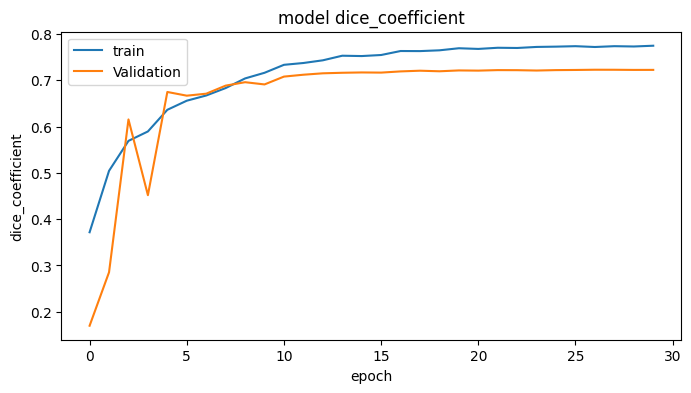

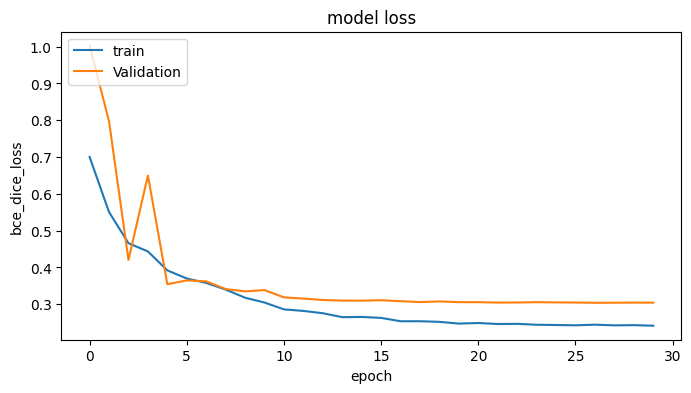

In [ ]:
# Visualizing history for dice_coefficient
plt.figure(figsize=(8, 4))
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('model dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history for loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
#model.load_weights('unet.h5')
loss, dc= model.evaluate(test_batches,verbose=1)
print('loss:',loss, 'dice_coefficient:',dc)


58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 646ms/step - dice_coefficient: 0.7458 - loss: 0.2811
loss: 0.2984055280685425 dice_coefficient: 0.730187177658081


#### 建模與訓練總結

嘗試自己設計Unet架構後經相同條件訓練val_dice_coefficient可達0.62以上，改用EfficientNetB0後val_dice_coefficient可達0.73以上

# Post Training - 訓練後優化

利用Prediction Threshold及Defect Pixel Threshold嘗試提升Dice_coefficient

In [ ]:
from keras.models import load_model

path='/content/drive/MyDrive/Colab Notebooks/mas-5/'

# 加載保存的模型
model = load_model(path+'unet_rest.h5',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})

In [ ]:
#灰階、改變大小、標準化、擴展一通道
def load_image(img_id, img_dir, target_size=(128, 800)):
    """
    根據圖像 ID 載入圖像，並將其調整為模型輸入形狀，並應用 Z 分數標準化。
    """
    img_path = f"{img_dir}/{img_id}"
    img = Image.open(img_path).convert('L')  # 將圖像轉換為灰階
    img = img.resize((target_size[1], target_size[0]), Image.Resampling.LANCZOS)  # (寬度, 高度)
    img_array = np.array(img, dtype=np.float32)

    # Z 分數標準化
    mean = np.mean(img_array)
    std = np.std(img_array)
    std = max(std, 1e-7)  # 防止除以零
    img_zscore = (img_array - mean) / std

    # 擴展維度以符合模型輸入形狀 (128, 800, 1)
    img_zscore = np.expand_dims(img_zscore, axis=-1)
    return img_zscore

In [ ]:
# 建立測試集真實遮罩
test_true_masks = np.array([
    np.stack([rle2mask(row[f'rle_{i+1}'], (128, 800)) for i in range(4)], axis=-1)
    for _, row in test_data.iterrows()
])

In [ ]:
# 生成 ImageId 與圖像資料的對應關係
image_ids = test_data['ImageId'].tolist()
img_dir='/content/train_images'
test_images = np.array([load_image(img_id, img_dir) for img_id in image_ids])

# 進行預測並保留 ImageId 與預測結果的對應
test_pred_masks = [
    (img_id, model.predict(np.expand_dims(img, axis=0))[0])
    for img_id, img in zip(image_ids, test_images)
]




1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

In [ ]:
test_pred_masks_thre = [
    model.predict(np.expand_dims(img, axis=0))[0]
    for img in test_images
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
#針對不同瑕疵種類給予不同prediction_thresholds及defect_pixel_thresholds


# 定義搜索範圍
prediction_thresholds = np.arange(0.1, 0.9, 0.1)
defect_pixel_thresholds = range(50, 800, 50)

# 生成所有可能的 (prediction_threshold, defect_pixel_threshold) 組合
combinations = [(pt, dt) for pt in prediction_thresholds for dt in defect_pixel_thresholds]
random_combinations = random.sample(combinations, k=min(len(combinations), 10))

@tf.function
def dice_coefficient_gpu(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smoothing_const
    )

def find_best_thresholds_for_class(class_id, true_masks, pred_masks, random_combinations):
    best_score = -1
    best_params = {}

    for pred_thresh, defect_thresh in random_combinations:
        true_class_masks = [mask[..., class_id - 1].astype(np.float32) for mask in true_masks]
        pred_class_masks = [(mask[..., class_id - 1] >= pred_thresh).astype(np.float32) for mask in pred_masks]

        filtered_pred_masks = [
            mask if np.sum(mask) >= defect_thresh else np.zeros_like(mask)
            for mask in pred_class_masks
        ]

        score = np.mean([
            dice_coefficient(y_true, y_pred).numpy()
            for y_true, y_pred in zip(true_class_masks, filtered_pred_masks)
        ])

        if score > best_score:
            best_score = score
            best_params = {'prediction_threshold': pred_thresh, 'defect_pixel_threshold': defect_thresh}

    return best_score, best_params

def parallel_search(true_masks, pred_masks, random_combinations):
    best_params_per_class = {}

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {
            executor.submit(find_best_thresholds_for_class, class_id, true_masks, pred_masks, random_combinations): class_id
            for class_id in range(1, 5)
        }

        for future in as_completed(futures):
            class_id = futures[future]
            try:
                score, params = future.result()
                best_params_per_class[class_id] = params
                print(f"Class {class_id} 最佳分數: {score}, 最佳參數: {params}")
            except Exception as e:
                print(f"Class {class_id} 發生錯誤: {e}")

    return best_params_per_class

# 呼叫平行搜尋
print("開始平行搜尋最佳參數...")
best_params_per_class = parallel_search(test_true_masks, test_pred_masks_thre, random_combinations)

# 顯示結果
print("每個類別的最佳參數:")
for class_id, params in best_params_per_class.items():
    print(f"Class {class_id}: {params}")


開始平行搜尋最佳參數...
Class 4 最佳分數: 0.9773718118667603, 最佳參數: {'prediction_threshold': 0.4, 'defect_pixel_threshold': 600}
Class 3 最佳分數: 0.8249664902687073, 最佳參數: {'prediction_threshold': 0.2, 'defect_pixel_threshold': 250}
Class 1 最佳分數: 0.9493027329444885, 最佳參數: {'prediction_threshold': 0.5, 'defect_pixel_threshold': 300}
Class 2 最佳分數: 0.9880940914154053, 最佳參數: {'prediction_threshold': 0.6, 'defect_pixel_threshold': 400}
每個類別的最佳參數:
Class 4: {'prediction_threshold': 0.4, 'defect_pixel_threshold': 600}
Class 3: {'prediction_threshold': 0.2, 'defect_pixel_threshold': 250}
Class 1: {'prediction_threshold': 0.5, 'defect_pixel_threshold': 300}
Class 2: {'prediction_threshold': 0.6, 'defect_pixel_threshold': 400}


In [ ]:
def apply_thresholds_per_class(pred_mask, class_thresholds):
    """
    根據每個類別的最佳參數應用不同的 threshold。
    """
    final_mask = np.zeros_like(pred_mask, dtype=np.uint8)

    for class_id in range(4):  # 針對 4 個類別
        pred_thresh = class_thresholds[class_id]['prediction_threshold']
        defect_thresh = class_thresholds[class_id]['defect_pixel_threshold']

        # 應用預測閾值
        binary_mask = (pred_mask[..., class_id] > pred_thresh).astype(np.uint8)

        # 過濾像素數不足的遮罩
        if np.sum(binary_mask) >= defect_thresh:
            final_mask[..., class_id] = binary_mask

    return final_mask


class_thresholds = {
    0: {'prediction_threshold': 0.5, 'defect_pixel_threshold': 300},  # Class 1
    1: {'prediction_threshold': 0.6, 'defect_pixel_threshold': 400},  # Class 2
    2: {'prediction_threshold': 0.2, 'defect_pixel_threshold': 250},  # Class 3
    3: {'prediction_threshold': 0.4, 'defect_pixel_threshold': 600}   # Class 4
}


In [ ]:
# 計算 avg_dice_coefficient（所有圖像和類別的全域展平後一次性計算）
@tf.function
def avg_dice_coefficient(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smoothing_const
    )

# 計算 class_dice_coefficient（每類別展平後分別計算）
@tf.function
def class_dice_coefficient(y_true, y_pred):
    class_dice_scores = []
    for class_id in range(4):
        y_true_f = tf.cast(tf.reshape(y_true[..., class_id], [-1]), tf.float32)
        y_pred_f = tf.cast(tf.reshape(y_pred[..., class_id], [-1]), tf.float32)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        smoothing_const = 1e-9
        dice = (2. * intersection + smoothing_const) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smoothing_const
        )
        class_dice_scores.append(dice)
    return class_dice_scores



# 計算 avg_dice_coefficient
y_true_all = np.stack(test_true_masks, axis=0)
y_pred_all = np.stack(
    [apply_thresholds_per_class(pred_mask, class_thresholds) for _, pred_mask in test_pred_masks],
    axis=0
)

avg_dice = avg_dice_coefficient(y_true_all, y_pred_all).numpy()
print(f"Avg Dice Coefficient: {avg_dice:.4f}")

# 計算 class_dice_coefficient
class_dice_scores = class_dice_coefficient(y_true_all, y_pred_all)

for class_id, dice_score in enumerate(class_dice_scores):
    print(f"Class {class_id + 1} Dice Coefficient: {dice_score.numpy():.4f}")

Avg Dice Coefficient: 0.7379
Class 1 Dice Coefficient: 0.4216
Class 2 Dice Coefficient: 0.5176
Class 3 Dice Coefficient: 0.7388
Class 4 Dice Coefficient: 0.7689


#### Post Training總結

礙於算力資料有限，在120組(prediction_thresholds的8組與defect_pixel_threshold的15組)可能性中只抽10組找出最佳。Dice_coefficient有微幅提升，證明利用prediction_thresholds及defect_pixel_threshold提升表現確實有用。希望有機會再利用更充裕的算力找尋更好的組合


# 觀看原圖像、原圖像+mask及+預測後+mask

In [ ]:
# # 保存 test_pred_masks
# file_path='/content/drive/MyDrive/Colab Notebooks/mas-5/test_pred_masks.pkl'
# def save_test_pred_masks(test_pred_masks, file_path):
#     try:
#         with open(file_path, 'wb') as f:
#             pickle.dump(test_pred_masks, f)
#         print(f"成功保存 test_pred_masks 到 {file_path}")
#     except Exception as e:
#         print(f"儲存 test_pred_masks 时出錯: {e}")

# # 加載 test_pred_masks
# def load_test_pred_masks(file_path):
#     if not os.path.exists(file_path):
#         print(f"文件 {file_path} 不存在")
#         return None

#     try:
#         with open(file_path, 'rb') as f:
#             test_pred_masks = pickle.load(f)
#         print(f"成功從 {file_path} 加載 test_pred_masks")
#         return test_pred_masks
#     except Exception as e:
#         print(f"加載 test_pred_masks 时出錯: {e}")
#         return None


In [ ]:
# import pickle
# # 儲存數據
# save_test_pred_masks(test_pred_masks,file_path)

# # # 加載數據
# # test_pred_masks = load_test_pred_masks(file_path)

成功保存 test_pred_masks 到 /content/drive/MyDrive/Colab Notebooks/mas-5/test_pred_masks.pkl


In [ ]:
def rle2mask_ori(rle_string, img_shape=(256, 1600)):
    if pd.isna(rle_string):
        return np.zeros(img_shape, dtype=np.uint8)

    rle_array = np.array([int(s) for s in rle_string.split()])
    starts_array = rle_array[::2] - 1
    lengths_array = rle_array[1::2]

    full_mask = np.zeros(256 * 1600, dtype=np.uint8)

    for start, length in zip(starts_array, lengths_array):
        full_mask[start:start+length] = 1

    return full_mask.reshape(img_shape, order='F')

In [ ]:
def visualize_result(img_id, img_dir, test_data, model_prediction, class_thresholds):
    img_path = f"{img_dir}/{img_id}"
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)

    true_masks = np.zeros((256, 1600, 4), dtype=np.uint8)
    class_ids = []

    for i in range(4):
        rle = test_data.loc[test_data['ImageId'] == img_id, f'rle_{i+1}'].values[0]

        if isinstance(rle, str) and rle.strip():
            class_ids.append(i + 1)
            mask = rle2mask_ori(rle, img_shape=(256, 1600))
            true_masks[..., i] = mask



    final_pred_mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    for i in range(4):
        pred_thresh = class_thresholds[i]['prediction_threshold']
        resized_pred = resize(model_prediction[..., i], (256, 1600), order=1, preserve_range=True, anti_aliasing=False)
        final_pred_mask[..., i] = (resized_pred >= pred_thresh).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    axes[0].imshow(img_array, cmap='gray')
    axes[0].set_title('original Image\nImageId: ' + img_id)
    axes[0].axis('off')

    axes[1].imshow(img_array, cmap='gray')
    combined_true_mask = np.sum(true_masks, axis=-1)
    axes[1].imshow(combined_true_mask, alpha=0.7, cmap='Reds')
    axes[1].set_title(f'true mask defect\nClassId: {class_ids if class_ids else "None"}')
    axes[1].axis('off')

    axes[2].imshow(img_array, cmap='gray')
    combined_pred_mask = np.sum(final_pred_mask, axis=-1)
    axes[2].imshow(combined_pred_mask, alpha=0.7, cmap='Blues')
    axes[2].set_title('predicted defect mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

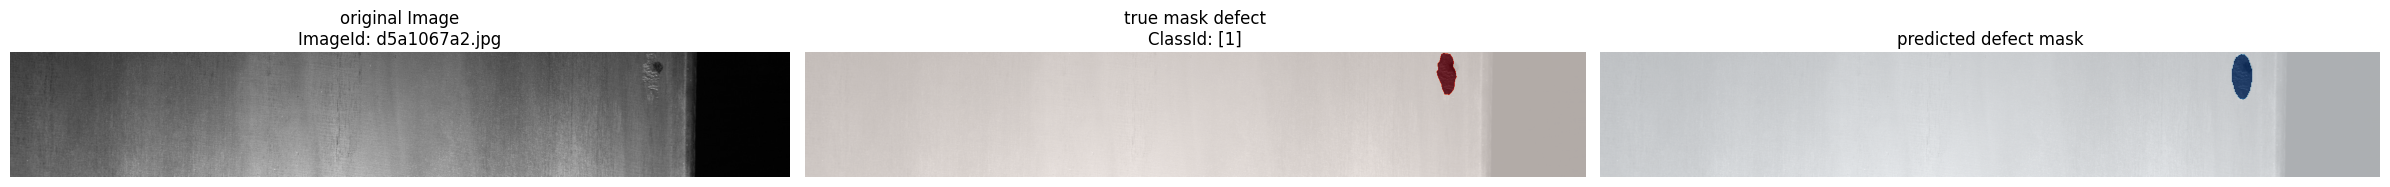

In [ ]:
#第一類



i = 583
img_id, model_prediction = test_pred_masks[i]
pred_mask = apply_thresholds_per_class(model_prediction, class_thresholds)


img = test_images[i].squeeze()  # 測試圖片 (128, 800)
true_mask = test_true_masks[i]  # 真實遮罩 (128, 800, 4)


visualize_result(img_id, img_dir, test_data, pred_mask, class_thresholds)

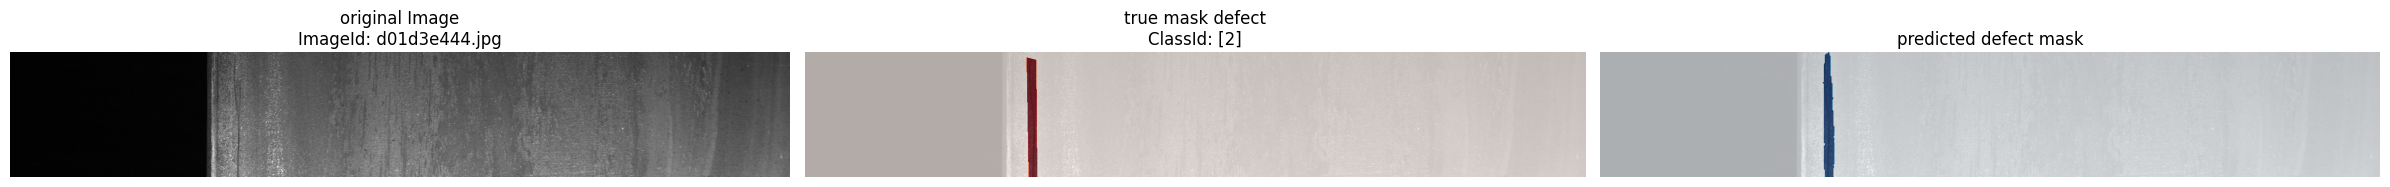

In [ ]:
#第二類


i = 1548
img_id, model_prediction = test_pred_masks[i]
pred_mask = apply_thresholds_per_class(model_prediction, class_thresholds)

img = test_images[i].squeeze()  # 測試圖片 (128, 800)
true_mask = test_true_masks[i]  # 真實遮罩 (128, 800, 4)

visualize_result(img_id, img_dir, test_data, pred_mask, class_thresholds)

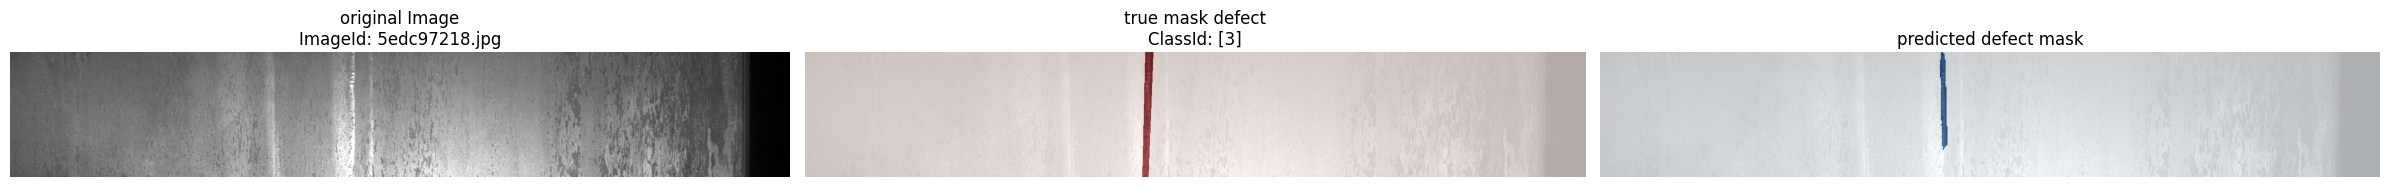

In [ ]:
#第三類


i = 370
img_id, model_prediction = test_pred_masks[i]
pred_mask = apply_thresholds_per_class(model_prediction, class_thresholds)


img = test_images[i].squeeze()  # 測試圖片 (128, 800)
true_mask = test_true_masks[i]  # 真實遮罩 (128, 800, 4)


visualize_result(img_id, img_dir, test_data, pred_mask, class_thresholds)

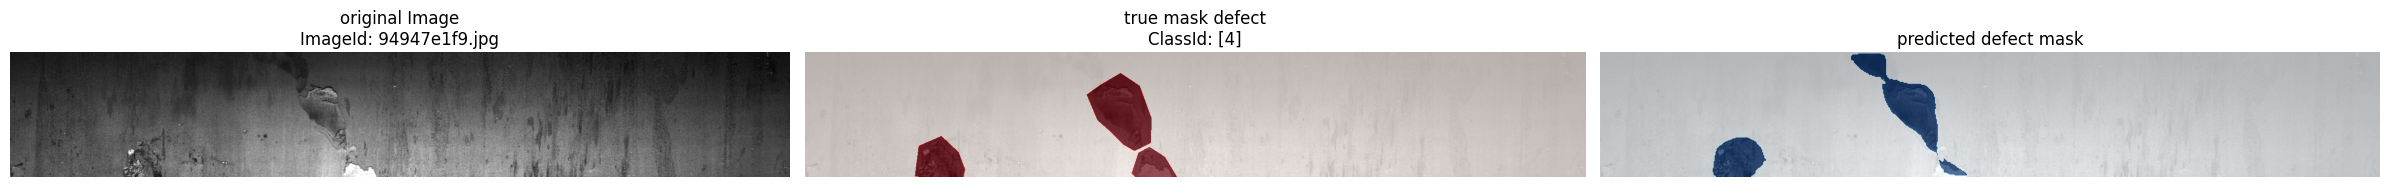

In [ ]:
#第四類

i = 0
img_id, model_prediction = test_pred_masks[i]
pred_mask = apply_thresholds_per_class(model_prediction, class_thresholds)

img = test_images[i].squeeze()  # 測試圖片 (128, 800)
true_mask = test_true_masks[i]  # 真實遮罩 (128, 800, 4)

visualize_result(img_id, img_dir, test_data, pred_mask, class_thresholds)